# Initial Setup

In a first step we collect all the graphs we need for some given pattern. For this we overapproximate the set of graphs in the spasm by simply taking all graphs with less vertices and less or equal number of edges. 
This forms the spasm space, for this space we compute the homomorphism basis (most of them usually will have coefficient 0, i.e., they aren't in the basis and will thus be ignored going forward).

In [43]:
from pact.spasmspace import SpasmSpace
from pact.graphwrapper import GraphWrapper
from pact.ui import default_progressbar
from pact.naive_exec import naive_pandas_plan_exec
from pact.naive_exec import _undir_df_degree_thres

import os
import tempfile
import subprocess
import networkx as nx
import matplotlib.pyplot as plt
import multiprocess as mp
import pandas as pd
import dill

import math
import json

plt.rcParams["figure.figsize"] = (2, 2)

_MIN_TW_INJECT = 1
THREADS = 48
INPUT_FILE = 'zinc/ZINC12k.json'

#adapt
CYCLE_LEN = 8
BASIS_FILE = f'bases/cycles/cycle{CYCLE_LEN}_basis.json'
with open(BASIS_FILE, 'rb') as f:
    basis_info = dill.loads(f.read())

spsp = basis_info['SpasmSpace']
Pbasis = basis_info['basis']

# code to skip K5 counting
# k5id = None
# for gid in Pbasis.keys():
#     G = spsp[gid]
#     if hasattr(G, 'clique') and G.clique == 5:
#         k5id = gid
#         break
# if k5id is not None:
#     del Pbasis[k5id]
    
OUTPUT_FILE = f'counts/zinc_with_c8_homs.json'

In [44]:
len(Pbasis)

35

# Helper Functions for Executing the Plans and Getting Vertexwise counts

In [45]:
# bit lazy but this needs to be the same as in the preprocessing
_MARK_VTX = 0

# convert a networkx graph and into a pandas DataFrame as expected by the naive plan executer
def nxGtoDf(nxG):
    edges = [{'s': a, 't': b} for a,b in nxG.edges()] + [{'s': b, 't': a} for a,b in nxG.edges()]
    host_df = pd.DataFrame(edges).drop_duplicates()
    return host_df

# returns a dictionary that maps v -> homs(F, host)[_MARK_VTX -> v]
# if a vertex of the host graph has no entry in the dictionary it means that there are 0 homs
def homcounts_per_vertex(F, host_df):
    state, empty = naive_pandas_plan_exec(F.plan, host_df, sliced_eval={})
    if not empty:
        finalcount = state['node$0']
        key = _MARK_VTX
        return finalcount.groupby(key)['count'].sum().to_dict()
    else:
        return {}

# Takes a networkx graph and the basis and computes the vertex_wise counts
# for all patterns in the basis into the graph. 
# Returns a dictionary that maps each vertex of the host (nxG) to a dictionary that itself maps basis graph ids to 
# the count of that basis into G
def counts_per_v(nxG, basis):
    ret = {v: {} for v in nxG.nodes}
    host_df = nxGtoDf(nxG)    
    for fid in basis.keys():
        f = spsp[fid]        
        if f.td.ghw < _MIN_TW_INJECT: # skip the acyclic ones
            continue
            
        if (not f.is_directed and hasattr(f, 'clique') and
            f.clique is not None and f.clique > 2):
            small_host = _undir_df_degree_thres(host_df, f.clique - 1)
            vcounts_f = homcounts_per_vertex(f, small_host)
        else:
            vcounts_f = homcounts_per_vertex(f, host_df)
        for v, vc in vcounts_f.items():
            ret[v][fid] = vc    
    return ret

# reads the edge_list input format from zinc and returns an networkx graph
def COOtonxG(edge_index):
    a = edge_index[0]
    b = edge_index[1]
    edges = list()
    for i in range(len(a)):
        e = list(sorted([a[i], b[i]]))
        if e not in edges:
            edges.append(e)
    return nx.from_edgelist(list(edges))

# Execute the Counting Plans on all Graphs

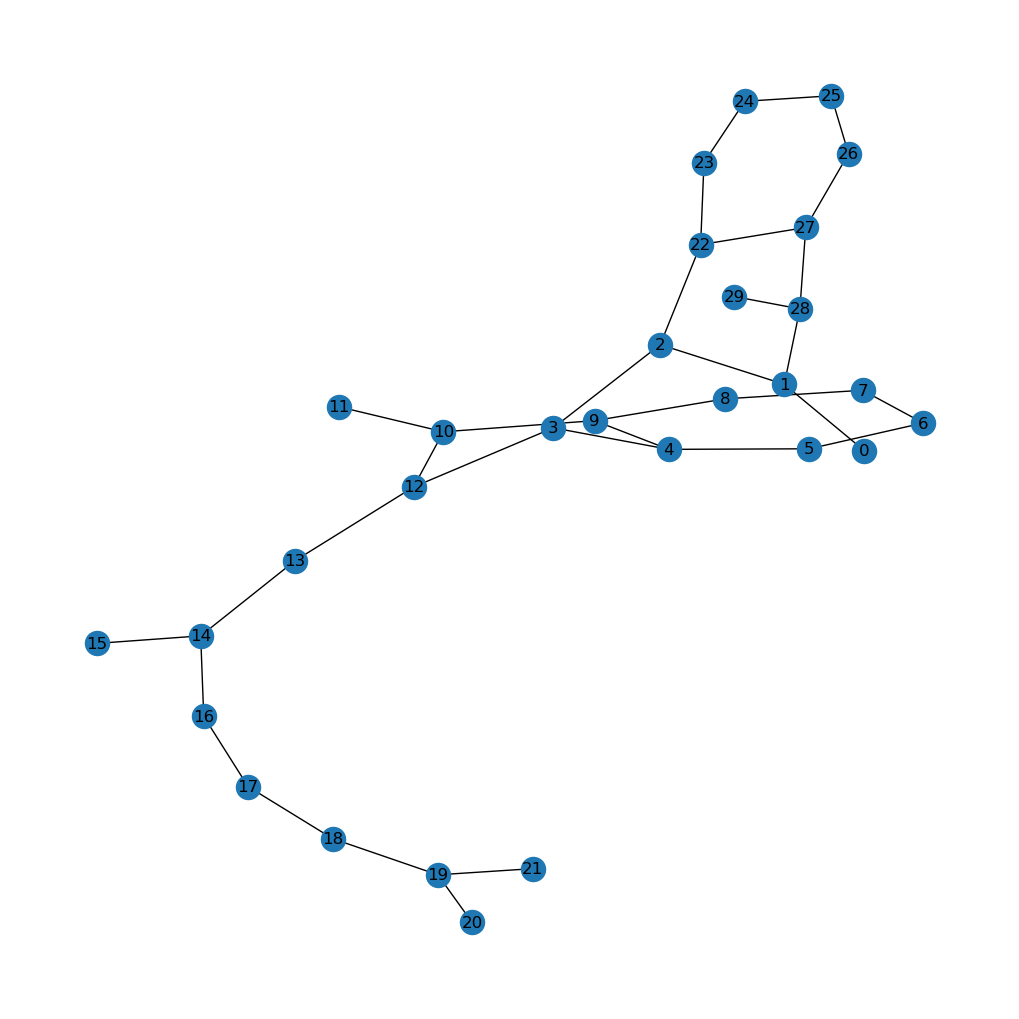

In [46]:
with open(INPUT_FILE, 'r') as f:
    zinc = json.loads(f.read())
    
ordered_basis = [gid for gid in Pbasis if spsp[gid].td.ghw >= _MIN_TW_INJECT]


graph = zinc['384']
graph_nx = COOtonxG(graph['edge_index'])

plt.figure(figsize=(10,10))
nx.draw(graph_nx, with_labels=True)

In [47]:

with open(INPUT_FILE, 'r') as f:
    zinc = json.loads(f.read())


ordered_basis = [gid for gid in Pbasis if spsp[gid].td.ghw >= _MIN_TW_INJECT]

# the main execution thing for each graph
# made into a separate function for easy parallelism
def _exec_helper(gitem):
    gid, gvals = gitem
    host = COOtonxG(gvals['edge_index'])
    
    tmpcount =  counts_per_v(host, Pbasis)
    homcounts = {}
    for v, vhoms in tmpcount.items():
        homcounts[v] = [vhoms.get(bgid, 0) for bgid in ordered_basis]
    return gid, homcounts
    
# main loop with fancy progressbar
with default_progressbar() as progress:
    pool = mp.Pool(THREADS)
    
    track = progress.track(pool.imap_unordered(_exec_helper, zinc.items()),
                           total=len(zinc))
    for gid, homcounts in track:
        zinc[gid]['homcounts'] = homcounts
        
        # this line is only for if there is only one specific pattern of interest (ie 8 cycle).
        # please comment it out if counting n-vertex homomorphism counts.
        zinc[gid]['coefficients'] = [float(Pbasis[gid]) for gid in ordered_basis]


with open(OUTPUT_FILE, 'w') as f:
    f.write(json.dumps(zinc))

Output()

### modification to test with different alpha coefficient breakdowns

In [ ]:
from pact.hombase import num_automorphisms
import copy

zinc_preaut = copy.deepcopy(zinc)
zinc_pref = copy.deepcopy(zinc)

AUTS = [num_automorphisms(spsp[gid]) for gid in ordered_basis]

for gid, gzinc in zinc_preaut.items():
    counts = gzinc['homcounts']
    alphas = gzinc['coefficients']
    
    counts_new = {v: [c/aut for c, aut in zip(vcs, AUTS)] for v, vcs in counts.items()}
    alpha_new = [a*aut for a, aut in zip(alphas, AUTS)]
    
    gzinc['homcounts'] = counts_new
    gzinc['coefficients'] = alpha_new
    
for gid, gzinc in zinc_pref.items():
    counts = gzinc['homcounts']
    alphas = gzinc['coefficients']
    
    fs = [a*aut for a, aut in zip(alphas, AUTS)]
    counts_new = {v: [c*f for c,f in zip(vcs, fs)] for v,vcs in counts.items()}
    alpha_new = [1/aut for aut in AUTS]
    
    gzinc['homcounts'] = counts_new
    gzinc['coefficients'] = alpha_new
    

OUTPUT_FILE_PREF = OUTPUT_FILE.replace('.json', '_pre_numerator.json')
OUTPUT_FILE_PREAUT = OUTPUT_FILE.replace('.json', '_pre_aut.json')

with open(OUTPUT_FILE_PREF, 'w') as f:
    f.write(json.dumps(zinc_pref))

with open(OUTPUT_FILE_PREAUT, 'w') as f:
    f.write(json.dumps(zinc_preaut))

# Some insight, playing around with coefficients

In [ ]:
zinc_preaut['0']['homcounts']

In [ ]:
zinc['0']['homcounts']

In [ ]:
zinc_pref['0']['homcounts']

In [ ]:
zinc['0']['coefficients'], zinc_preaut['0']['coefficients']

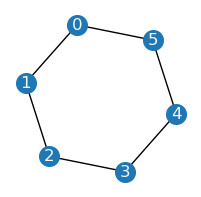

In [29]:
"""
Draw the basis nicely
"""
rows = math.ceil(len(Pbasis)/5)
fig = plt.figure(figsize=(5*2,2*rows))
gs = fig.add_gridspec(nrows=rows, ncols=5)

r,c = 0,0

for gid, alpha in Pbasis.items():
    fig.add_subplot(gs[r,c])
    
    # spsp[gid] is the GraphWrapper object with id = gid
    # the .graph attribute here is the raw networkx object used for drawing
    nx.draw(spsp[gid].graph, node_size=200, with_labels=True, font_color='whitesmoke')
    # plt.title(f'coefficient: {alpha.digits()}\n')
    
    
    c+=1
    if c >= 5:
        r += 1
        c = 0
plt.tight_layout()

In [ ]:
len(Pbasis)

In [ ]:
stats = {}
for i, pid in enumerate(ordered_basis):
    P = spsp[pid]
    stats[pid] = []
    for G, Gvals in zinc.items():
        homsinG = sum(homs[i] for homs in Gvals['homcounts'].values())
        stats[pid].append(homsinG)
        
df = pd.DataFrame.from_dict(stats)

In [ ]:
n = len(ordered_basis)
fig = plt.figure(figsize=(12,3.5*(n+1)))
gs = fig.add_gridspec(nrows=n+1, ncols=2, width_ratios=(0.25,0.75), hspace=1)

globalcount = None
for pid, coeff in Pbasis.items():
    if globalcount is None:
        globalcount = coeff * df[pid]
    else:
        globalcount += coeff * df[pid]
        


for row, pid in enumerate(ordered_basis):
    alpha = Pbasis[pid]
    P = spsp[pid]
    fig.add_subplot(gs[row,0])
    nx.draw(P.graph)
    plt.title(f'coefficient: {alpha.digits()}\n')
    
    fig.add_subplot(gs[row,1])
    plt.title(f'ID {pid}')
    df[pid].plot(kind='hist', bins=50, grid=True)

df['subgs'] = globalcount.rename('test').astype(float)

fig.add_subplot(gs[n,1])
df[df['subgs']>0]['subgs'].plot(kind='hist', bins=20, grid=True)

ax = fig.add_subplot(gs[n,0])
ax.set_axis_off()
txt = plt.text(0, 0.5, f'Total Counts of C{CYCLE_LEN}', fontsize='x-large')
txt.set_clip_on(False)

plt.savefig(f'{OUTPUT_FILE}.png')
plt.savefig(f'{OUTPUT_FILE}.pdf')

# Sanity Check

In [ ]:
for g, gvals in zinc.items():
    homs = gvals['homcounts']
    alpha = gvals['coefficients']
    c = 0
    for v in homs.keys():
        c += sum([a*b for a,b in zip(homs[v], alpha)])
    if abs(round(c)-c) > 0.000001:
        print(f'FAIL at {g} count {c}')

In [ ]:
for g, gvals in zinc_pref.items():
    homs = gvals['homcounts']
    alpha = gvals['coefficients']
    c = 0
    for v in homs.keys():
        c += sum([a*b for a,b in zip(homs[v], alpha)])
    if abs(round(c)-c) > 0.000001:
        print(f'FAIL at {g} count {c}')

In [ ]:
for g, gvals in zinc_preaut.items():
    homs = gvals['homcounts']
    alpha = gvals['coefficients']
    c = 0
    for v in homs.keys():
        c += sum([a*b for a,b in zip(homs[v], alpha)])
    if abs(round(c)-c) > 0.000001:
        print(f'FAIL at {g} count {c}')